In [30]:
from ultralytics import YOLO
import os
import numpy as np
import pandas as pd
from pathlib import Path

In [ ]:
weight_path = "/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/yolo/outputs/2025-05-07/19-51-56/42/yolo11l_train/weights"
total_epoch = 70
data_path = "../../parse_data/yolo_dataset/images/val"

for i in range(total_epoch):
    # os.makedirs(f"result_{i}", exist_ok=True)
    # os.chdir(f"result_{i}")
    weight = os.path.join(weight_path ,f"epoch{i}.pt")
    model = YOLO(weight)

    results = model.predict(
    source=data_path,  # 画像フォルダでも単一画像でもOK
    conf=0.0,
    max_det=1,
    save=False,               # ファイル出力はせず戻り値のみ
    save_txt=False
    )

    

In [20]:
import pandas as pd
column = ["obj_name", "x_max", "y_max", "x_min", "y_min"]
df = pd.read_csv("/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/parse_data_add_val_data/yolo_dataset/labels/val/tomo_ff505c_z0110_y0816_x0678.txt",
                 sep=r"\s+",           # ← 連続する空白文字をすべて区切り文字とみなす正規表現
                engine="python",      # ← 正規表現 sep を使う場合は python エンジン推奨
                header=None,          # ← ヘッダー行なし
                 names=column)

In [21]:
print(df["obj_name"].item)

<bound method IndexOpsMixin.item of 0    0
Name: obj_name, dtype: int64>


In [28]:
if df["obj_name"].item() != 0:
    print(3)

In [29]:
df["obj_name"].item()

0

In [33]:
weight_path = "/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/yolo/outputs/2025-05-07/19-51-56/42/yolo11l_train/weights"
weight = os.path.join(weight_path ,f"epoch{21}.pt")
model = YOLO(weight)

In [34]:
data_path = "../../parse_data/yolo_dataset/images/val"
results = model.predict(
    source=data_path,  # 画像フォルダでも単一画像でもOK
    conf=0.0,
    max_det=1,
    save=False,               # ファイル出力はせず戻り値のみ
    save_txt=False
    )


image 1/792 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_4/../../parse_data/yolo_dataset/images/val/tomo_00e463_z0218_y0379_x0144.jpg: 928x960 1 motor, 41.8ms
image 2/792 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_4/../../parse_data/yolo_dataset/images/val/tomo_00e463_z0219_y0379_x0144.jpg: 928x960 1 motor, 24.5ms
image 3/792 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_4/../../parse_data/yolo_dataset/images/val/tomo_00e463_z0220_y0379_x0144.jpg: 928x960 1 motor, 24.3ms
image 4/792 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_4/../../parse_data/yolo_dataset/images/val/tomo_00e463_z0221_y0241_x0643.jpg: 928x960 1 motor, 24.2ms
image 5/792 /mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/survey/survey_4/../../parse_data/yolo_dataset/images/val/tomo_00e463_z0221_y0262_x0628.jpg: 928x960 1 motor, 24.2ms
image 6/792 /mnt/c/Users/tkdgk/BYU---Locating-Bacteria

In [65]:
column = ["obj_name", "x_max", "y_max", "x_min", "y_min"]
voxel_df = pd.read_csv("/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/input/byu-locating-bacterial-flagellar-motors-2025/train_labels.csv")
threthold = 9000
n_image = len(results)
TP = 0
FP = 0
FN = 0
conf = 0.5
dist = []
for r in results: 
    no_pred = False
    if r.boxes.conf.cpu().item() < conf:
        no_pred = True

    img_path = r.path  # or r.orig_img if path 欄がない場合は適宜読み替え
    filename = os.path.basename(img_path)
    base, ext = os.path.splitext(filename)           # base='tomo_00e463_z0218_y0379_x0144', ext='.jpg'
    txt_filename = base + '.txt'
    anno_path = os.path.join("../../parse_data_add_val_data/yolo_dataset/labels/val", txt_filename)
    df = pd.read_csv(anno_path,
                sep=r"\s+",           # ← 連続する空白文字をすべて区切り文字とみなす正規表現
                engine="python",      # ← 正規表現 sep を使う場合は python エンジン推奨
                header=None,          # ← ヘッダー行なし
                names=column)

    no_objecct = False
    if (df["obj_name"].item() == 0) & no_pred:
        FN += 1
        continue
    elif df["obj_name"].item() == 0:
        true_center = [(df["x_max"]-df["x_min"])/2, (df["y_max"]-df["y_min"])/2]
    elif no_pred:#背景クラスをうまく予想
        continue
    else:
        FP += 1
        continue

    stem = Path(filename).stem                   # 'tomo_00e463_z0218_y0379_x0144'
    parts = stem.split('_')                      # ['tomo','00e463','z0218','y0379','x0144']
    prefix = parts[0] + '_' + parts[1]           # 'tomo_00e463'

    if r.orig_shape[0] >= 960:
        true_center[0] *= voxel_df.loc[voxel_df["tomo_id"]==prefix, "Array shape (axis 2)"].mean()/960

    if r.orig_shape[1] >= 960:
        true_center[1] *= voxel_df.loc[voxel_df["tomo_id"]==prefix, "Array shape (axis 1)"].mean()/960


    vs = voxel_df.loc[voxel_df["tomo_id"]==prefix, "Voxel spacing"].mean()

    # 予測ボックスを numpy に
    pred = r.boxes.xyxy.cpu().numpy()      # shape (M,4)

    pred_center = [(pred[:,0]+pred[:,2])/2, (pred[:,1]+pred[:,3])/2 ]

    # ピクセル距離の行列を計算 (M×K)
    # 予測 i と GT j の距離 d[i,j] (ピクセル)
    diff = ((true_center[0]-pred_center[0])**2 + (true_center[1]-pred_center[1])**2)**0.5

    phys_dists = diff * vs                           # (M, K)
    dist.append(phys_dists)

    # マッチ行列：物理距離 ≤ voxel_spacing を True
    if phys_dists.item() <= threthold:
        TP += 1
    else:
        FP += 1                          




In [73]:
pred_center

[array([     676.51], dtype=float32), array([     815.29], dtype=float32)]

In [79]:
pred[:, 3].item() 

825.9623413085938

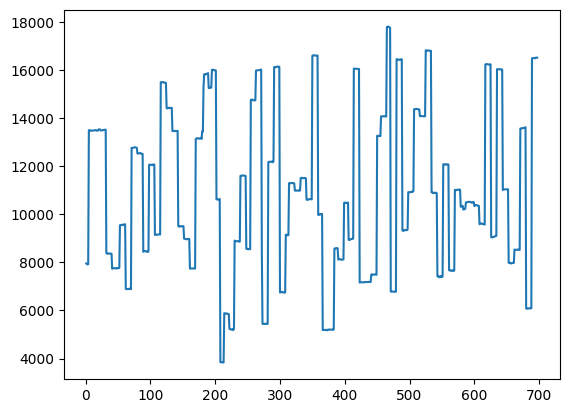

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
plot = np.linspace(1, len(dist), len(dist))
plt.plot(plot, dist)


それっぽいのができた

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

def evaluate_detections(results,
                        threshold: float,
                        conf: float,
                        labels_dir: str = "../../parse_data_add_val_data/yolo_dataset/labels/val",
                        voxel_csv_path: str = "/mnt/c/Users/tkdgk/BYU---Locating-Bacterial-Flagellar-Motors/input/byu-locating-bacterial-flagellar-motors-2025/train_labels.csv",):

    # 1) 前処理: VOXEL データ読み込み & カラム定義
    column = ["obj_name", "x_max", "y_max", "x_min", "y_min"]
    voxel_df = pd.read_csv(voxel_csv_path)

    TP = 0
    FP = 0
    FN = 0
    dists = []

    for r in results:
        # 2) 予測の有無判定
        no_pred = (r.boxes.conf.cpu().item() < conf)

        # 3) アノテーション読み込み
        fname = os.path.basename(r.path)
        base, _ = os.path.splitext(fname)
        txt_fname = base + ".txt"
        anno_path = os.path.join(labels_dir, txt_fname)

        df = pd.read_csv(
            anno_path,
            sep=r"\s+",
            engine="python",
            header=None,
            names=column
        )

        # 4) GT ボックス有無ごとの分岐
        if df["obj_name"].item() == 0 and no_pred:
            FN += 1
            continue
        elif df["obj_name"].item() == 0:
            # 背景中にモーターがない画像
            continue
        elif no_pred:
            # モーターあり画像なのに予測なし
            FN += 1
            continue

        # 5) 真の中心座標計算
        true_center = [
            (df["x_max"].item() + df["x_min"].item()) / 2,
            (df["y_max"].item() + df["y_min"].item()) / 2
        ]

        # 6) 元画像サイズに合わせてスケール補正
        stem = Path(fname).stem
        prefix = "_".join(stem.split("_")[:2])  # tomo_00e463 の部分
        # Z軸方向
        if r.orig_shape[0] >= 960:
            scale_z = (
                voxel_df.loc[voxel_df["tomo_id"]==prefix, "Array shape (axis 2)"]
                       .mean() / 960
            )
            true_center[0] *= scale_z
        # Y軸方向
        if r.orig_shape[1] >= 960:
            scale_y = (
                voxel_df.loc[voxel_df["tomo_id"]==prefix, "Array shape (axis 1)"]
                       .mean() / 960
            )
            true_center[1] *= scale_y

        # 7) Voxel spacing
        vs = voxel_df.loc[voxel_df["tomo_id"]==prefix, "Voxel spacing"].mean()

        # 8) 予測中心座標
        pred = r.boxes.xyxy.cpu().numpy()  # shape (M,4)
        pred_center = np.column_stack([
            (pred[:,0] + pred[:,2]) / 2,
            (pred[:,1] + pred[:,3]) / 2
        ])  # (M,2)

        # 9) 距離計算（ピクセル→物理距離）
        pix_dists = np.linalg.norm(pred_center - true_center, axis=1)  # (M,)
        phys_dists = pix_dists * vs                                  # (M,)
        dists.extend(phys_dists.tolist())

        # 10) TP/FP 判定（最も近い予測だけをマッチとする場合は np.min(phys_dists) を使う）
        min_dist = phys_dists.min()
        if min_dist <= threshold:
            TP += 1
        else:
            FP += 1

    return TP, FP, FN, dists

# --- 使い方例 ---
# TP, FP, FN, dists = evaluate_detections(results, threshold=9000, conf=0.5)
